In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount = True)

Mounted at /content/drive


In [ ]:

# Define paths to the training, validation, and test datasets
train_folder = '/content/drive/MyDrive/dataset/train'
test_folder = '/content/drive/MyDrive/dataset/test'
validate_folder = '/content/drive/MyDrive/dataset/valid'

# Define paths to the specific classes within the dataset
normal_folder = '/content/drive/MyDrive/dataset/train/normal'
adenocarcinoma_folder = '/content/drive/MyDrive/dataset/train/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib'
large_cell_carcinoma_folder = '/content/drive/MyDrive/dataset/train/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa'
squamous_cell_carcinoma_folder = '/content/drive/MyDrive/dataset/train/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa'

# Import necessary libraries
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
np.random.seed(0)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler # its used for scale and normalize data Scales features to a specific range, usually [0, 1] or [-1, 1].
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC #support vector classifier
from sklearn.decomposition import PCA # principal component analysis Reduces computational complexity for high-dimensional datasets.
from sklearn.preprocessing import LabelEncoder
import pickle
from PIL import Image


import tensorflow as tf
tf.random.set_seed(0)
import tensorflow.keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout2D, Activation, Lambda, Flatten, LSTM
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import utils
from tensorflow.keras import layers, models
import random
random.seed(0)
import os

print("Libraries Imported")

Libraries Imported


to check number of class which is 4

In [ ]:
print(os.listdir("/content/drive/MyDrive/dataset"))
print(os.listdir("/content/drive/MyDrive/dataset/test")[:5])
print(os.listdir("/content/drive/MyDrive/dataset/train")[:5])
print(os.listdir("/content/drive/MyDrive/dataset/valid")[:5])
print(len(os.listdir("/content/drive/MyDrive/dataset/test")))
print(len(os.listdir("/content/drive/MyDrive/dataset/train")))
print(len(os.listdir("/content/drive/MyDrive/dataset/valid")))

['train', 'test', 'valid']
['normal', 'large.cell.carcinoma', 'squamous.cell.carcinoma', 'adenocarcinoma']
['normal', 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa', 'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib', 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa']
['large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa', 'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib', 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa', 'normal']
4
4
4


and specfic file adenocarcinoma have 120 img

In [ ]:
print(len(os.listdir("/content/drive/MyDrive/dataset/test/adenocarcinoma")))
print(os.listdir("/content/drive/MyDrive/dataset/test/adenocarcinoma")[:5])
print(len(os.listdir("/content/drive/MyDrive/dataset/train/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib")))
print(os.listdir("/content/drive/MyDrive/dataset/train/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib")[:5])
print(len(os.listdir("/content/drive/MyDrive/dataset/valid/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib")))
print(os.listdir("/content/drive/MyDrive/dataset/valid/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib")[:5])

120
['000132.png', '000133 (2).png', '000116 (5).png', '000172 (3).png', '000148 (8).png']
195
['000024.png', '000087 (4).png', '000068 (9).png', '000054 (6).png', '000067.png']
23
['000109 (3).png', '000112 (9).png', '000115 (9).png', '000113.png', '000108 (8).png']


data preprocesssing


In [ ]:
#dataset path
train_folder = '/content/drive/MyDrive/dataset/train'
test_folder = '/content/drive/MyDrive/dataset/test'
validate_folder = '/content/drive/MyDrive/dataset/valid'

In [ ]:
# Initialize the image data generators for training and testing
print("Reading training images from:", train_folder)
print("Reading validation images from:", validate_folder)

train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

Reading training images from: /content/drive/MyDrive/dataset/train
Reading validation images from: /content/drive/MyDrive/dataset/valid


(264, 409, 4)


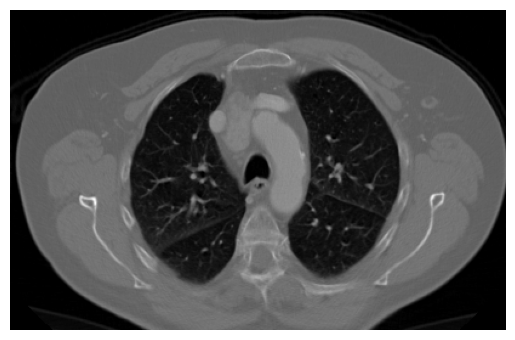

In [ ]:
# to seeing an image
image_path = "/content/drive/MyDrive/dataset/train/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib/000000 (6).png"

# reading thhe image
img = plt.imread(image_path)
print(img.shape)
# displaying the image
plt.imshow(img)
plt.axis('off')
plt.show()
#(245, 315, 4 respresent the aplha transperancy)

In [ ]:
img_size = (350,350)
batch_size = 8 # this is used to that we are training the model in batch and each batch size is 8

making the pipie line in which the image are getting resized
and then plitting it into train teest split

In [ ]:
#image parameter
data_gen = ImageDataGenerator(
    rescale = 1./255,
    validation_split = 0.35 #use 33% of data validation

)

In [ ]:
# train generator
train_generator = data_gen.flow_from_directory(     # flow_from_directory will gvie the label to data present
    train_folder,
    target_size = img_size,
    batch_size = batch_size,
    color_mode ="rgb",
    class_mode = 'categorical'
)

Found 613 images belonging to 4 classes.


In [ ]:
# vladidation generator
validation_generator = data_gen.flow_from_directory(
    test_folder,
    target_size = img_size,
    batch_size = batch_size,
    color_mode ="rgb",
    class_mode = 'categorical'
)

Found 315 images belonging to 4 classes.


In [ ]:
# Set up callbacks for learning rate reduction, early stopping, and model checkpointing
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

learning_rate_reduction = ReduceLROnPlateau(monitor='loss', patience=5, verbose=2, factor=0.5, min_lr=0.000001)
early_stops = EarlyStopping(monitor='loss', min_delta=0, patience=6, verbose=2, mode='auto')
checkpointer = ModelCheckpoint(filepath='best_model.weights.h5', verbose=2, save_best_only=True, save_weights_only=True)

In [ ]:
## Load a pre-trained model (Xception) without the top layers and freeze its weights
pretrained_model = tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=[*img_size, 3])
pretrained_model.trainable = False

convolution neural network

In [ ]:
#architeture of model
output_size = 4

#GlobalAveragePooling2D =
#model defintion

# Create a new model with the pre-trained base and additional layers for classification
model = Sequential()
model.add(pretrained_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(output_size , activation='softmax'))

#model.add(layers.GlobalAveragePooling2D())
#model.add(layers.Dense(train_generator.num_classes, activation='softmax')) # Add a Dense layer with the correct number of output neurons


# adding layers where it have 32 filters  ncreses beacause to model to get more complex feature and 3,3 metrics input shape menstion the size you are working on * unpack
#model.add(layers.Conv2D(32,(3,3),activation = 'relu',input_shape = (*img_size,3)))
##model.add(layers.Conv2D(64,(3,3),activation = 'relu'))
#model.add(layers.MaxPooling2D(2,2))

#model.add(layers.Flatten()) # hepl to flatten data in 1 d
#model.add(layers.Dense(350,activation = 'relu'))
#model.add(layers.Dense(train_generator.num_classes,activation = 'softmax')) # softmaax use sigmod 2

In [ ]:
print("Pretrained model used:")
pretrained_model.summary()

Pretrained model used:


Model: "xception"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 350, 350, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 174, 174, 32)   │            864 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 174, 174, 32)   │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 174, 174, 32)   │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 172, 172, 64)   │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 172, 172, 64)   │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 172, 172, 64)   │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 172, 172, 128)  │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 172, 172, 128)  │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 172, 172, 128)  │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 172, 172, 128)  │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 172, 172, 128)  │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_11 (Conv2D)        │ (None, 86, 86, 128)    │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 86, 86, 128)    │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├──────────────────────

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,861,480 (79.58 MB)

In [ ]:
#model summary
print("Final model created:")

model.summary()

Final model created:


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ xception (Functional)                │ (None, 11, 11, 2048)        │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 4)                   │           8,196 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,869,676 (79.61 MB)

 Trainable params: 8,196 (32.02 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [ ]:
#compile  the model
model.compile(optimizer = 'adam',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy']

)

traning the model

In [ ]:
#traning the model
#epoch meaning the model is traning through all the data and go trough it
#loss is the difference between the predicted value and the true value
history = model.fit(
    train_generator,
    steps_per_epoch=25,
    epochs=25,
    callbacks=[learning_rate_reduction, early_stops, checkpointer],
    validation_data=validation_generator,
    validation_steps=20
)

Epoch 1/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.3710 - loss: 1.3097
Epoch 1: val_loss improved from inf to 1.21338, saving model to best_model.weights.h5
25/25 ━━━━━━━━━━━━━━━━━━━━ 19s 435ms/step - accuracy: 0.3747 - loss: 1.3070 - val_accuracy: 0.3938 - val_loss: 1.2134 - learning_rate: 0.0010
Epoch 2/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.4573 - loss: 1.1328
Epoch 2: val_loss improved from 1.21338 to 1.00679, saving model to best_model.weights.h5
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 220ms/step - accuracy: 0.4587 - loss: 1.1309 - val_accuracy: 0.5355 - val_loss: 1.0068 - learning_rate: 0.0010
Epoch 3/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - accuracy: 0.6366 - loss: 0.9516 - learning_rate: 0.0010
Epoch 4/25
 2/25 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.7812 - loss: 0.7313
Epoch 4: val_loss improved from 1.00679 to 0.94718, saving model to best_model.weights.h5
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 0.6950 - loss: 0.7923 - val_accur

In [ ]:

print("Final training accuracy =", history.history['accuracy'][-1])
print("Final testing accuracy =", history.history['val_accuracy'][-1])

Final training accuracy = 0.8426395654678345
Final testing accuracy = 0.668749988079071


In [ ]:
# Function to display training curves for loss and accuracy
def display_training_curves(training, validation, title, subplot):
    if subplot % 10 == 1:
        plt.subplots(figsize=(10, 10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model ' + title)
    ax.set_ylabel(title)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

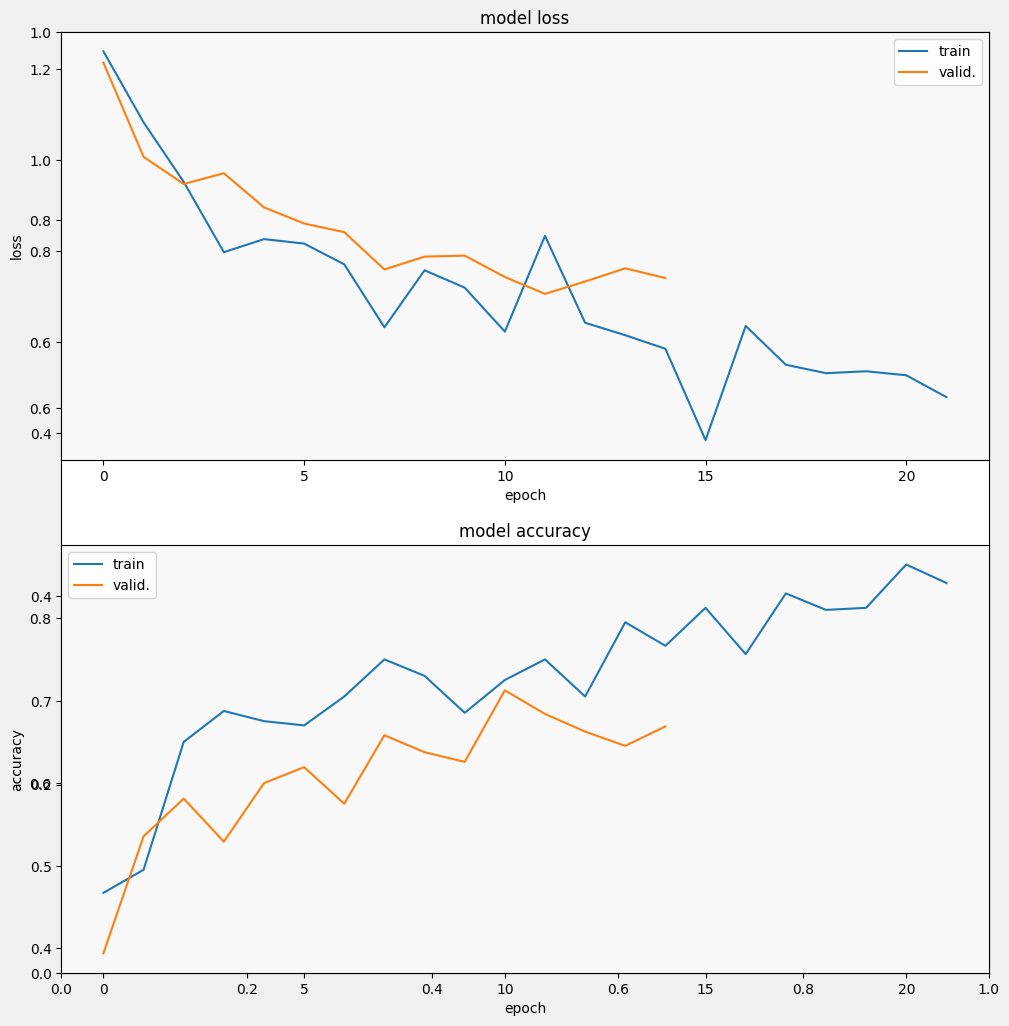

In [ ]:
# Display training curves for loss and accuracy
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 211)
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 212)

In [ ]:
import pickle

with open('lung_cancer_mri.pkl', 'wb') as file:
    pickle.dump(model, file)

In [ ]:
# function to load and preprocess the image using pillow
from tensorflow.keras.utils import load_img # import load_img
def load_and_preprocess_image(image_path,target_size):
    img = load_img(image_path, target_size=target_size)
  #covert the image
    img_array = np.array(img)
    # Convert the image array to float32 before division
    img_array = img_array.astype(np.float32)
  #add batch size
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Rescale the image like the training images
    return img_array

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
The image belongs to class: adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib


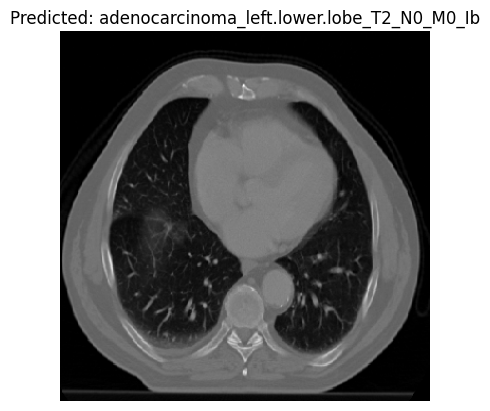

In [ ]:
# Load, preprocess, and predict the class of an image
img_path = '/content/drive/MyDrive/dataset/valid/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib/000109 (4).png'
img = load_and_preprocess_image(img_path, img_size)
predictions = model.predict(img)
predicted_class = np.argmax(predictions[0])
class_labels = list(train_generator.class_indices.keys())
predicted_label = class_labels[predicted_class]

print(f"The image belongs to class: {predicted_label}")

# Display the image with the predicted class
plt.imshow(load_img(img_path, target_size=img_size))
plt.title(f"Predicted: {predicted_label}")
plt.axis('off')
plt.show()